In [1]:
import meep as mp
import meep_adjoint as mpa
import autograd.numpy as npa
import numpy as np
from matplotlib import pyplot as plt
import nlopt
mp.quiet(quietval=True)

Using MPI version 3.1, 1 processes


In [2]:
resolution = 10

Sx = 6
Sy = 5
cell_size = mp.Vector3(Sx,Sy)

pml_layers = [mp.PML(1.0)]

fcen = 1/1.55
width = 0.2
fwidth = width * fcen
source_center  = [-1.5,0,0]
source_size    = mp.Vector3(0,2,0)
kpoint = mp.Vector3(1,0,0)
src = mp.GaussianSource(frequency=fcen,fwidth=fwidth)
source = [mp.EigenModeSource(src,
                    eig_band = 1,
                    direction=mp.NO_DIRECTION,
                    eig_kpoint=kpoint,
                    size = source_size,
                    center=source_center)]

seed = 24
np.random.seed(seed)
Nx = 10
Ny = 10

design_region = mp.Volume(center=mp.Vector3(), size=mp.Vector3(1, 1, 0))
rho_vector = 11*np.random.rand(Nx*Ny) + 1
basis = mpa.BilinearInterpolationBasis(volume=design_region,Nx=Nx,Ny=Ny,rho_vector=rho_vector)

geometry = [
    mp.Block(center=mp.Vector3(x=-Sx/4), material=mp.Medium(index=3.45), size=mp.Vector3(Sx/2, 0.5, 0)), # horizontal waveguide
    mp.Block(center=mp.Vector3(), material=mp.Medium(index=3.45), size=mp.Vector3(0.5, mp.inf, 0)),  # vertical waveguide
    mp.Block(center=design_region.center, size=design_region.size, epsilon_func=basis.func()) # design region
]

sim = mp.Simulation(cell_size=cell_size,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=source,
                    resolution=resolution)

In [3]:
mode = 1

TE0 = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(x=-1),size=mp.Vector3(y=1.5)),mode)
TE_top = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,1,0),size=mp.Vector3(x=1.5)),mode)
TE_bottom = mpa.EigenmodeCoefficient(sim,mp.Volume(center=mp.Vector3(0,-1,0),size=mp.Vector3(x=1.5)),mode,forward=False)
ob_list = [TE0,TE_top,TE_bottom]

In [4]:
def J(source,top,bottom):
    return 0.5*npa.abs(top/source) ** 2 + 0.5*npa.abs(bottom/source) ** 2

In [5]:
opt = mpa.OptimizationProblem(
    simulation = sim,
    objective_function = J,
    objective_arguments = ob_list,
    basis = [basis],
    fcen = fcen,
    decay_fields=[mp.Ez]
)

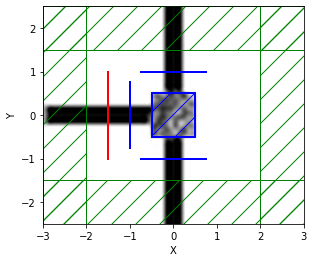

In [6]:
opt.plot2D(True)
plt.show()

In [7]:
evaluation_history = []
def f(x, grad):
    f0, dJ_deps, dg = opt([x])
    if grad.size > 0:
        grad[:] = np.squeeze(basis.get_basis_vjp(dJ_deps[0],dg[0]))
    evaluation_history.append(np.real(f0))
    return np.real(f0)

In [8]:
algorithm = nlopt.LD_MMA
n = Nx * Ny
maxeval = 10

solver = nlopt.opt(algorithm, n)
solver.set_lower_bounds(1)
solver.set_upper_bounds(12)
solver.set_max_objective(f)
solver.set_maxeval(maxeval)
x = solver.optimize(rho_vector)

Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...


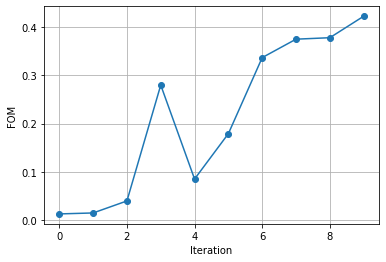

In [9]:
plt.figure()
plt.plot(evaluation_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('FOM')
plt.show()

In [10]:
def J(source,top,bottom):
    return npa.mean(0.5*npa.abs(top/source) ** 2 + 0.5*npa.abs(bottom/source) ** 2)
nf = 50
opt.nf = nf
opt.df = fwidth
opt.objective_function = J

In [11]:
f0, dJ_deps, dg = opt([rho_vector])
print(dJ_deps[0].shape)

Starting forward run...
Starting adjoint run...
Calculating gradient...
(12, 12, 1, 50)


In [12]:
evaluation_history = []
def f(x, grad):
    f0, dJ_deps, dg = opt([x])
    if grad.size > 0:
        grad[:] = np.sum(basis.get_basis_vjp(dJ_deps[0],dg[0]),axis=1)
    evaluation_history.append(np.real(f0))
    return np.real(f0)
solver.set_max_objective(f)
x = solver.optimize(rho_vector)

Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...


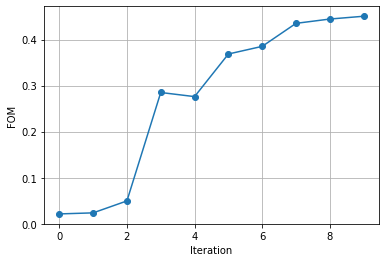

In [13]:
plt.figure()
plt.plot(evaluation_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('FOM')
plt.show()

In [14]:
def J(source,top,bottom):
    return npa.abs(1 - 0.5*npa.abs(top/source) ** 2 + 0.5*npa.abs(bottom/source) ** 2) ** 2

opt.objective_function = J
nf = 100
opt.nf = nf
opt.df = fwidth

In [15]:
evaluation_history = []
def f(x, grad):
    t = x[0]
    v = x[1:]
    if grad.size > 0:
        grad[0] = 1
        grad[1:] = 0
    return t

In [16]:
def c(result,x,grad):
    t = x[0]
    v = x[1:]
    f0, dJ_deps, dg = opt([v])
    if grad.size > 0:
        grad[:,0] = 0 # gradient w.r.t. "t"
        grad[:,1:] = basis.get_basis_vjp(dJ_deps[0],dg[0]).transpose() # gradient w.r.t. "rho"
    evaluation_history.append(np.max(np.real(f0)))
    result[:] = np.real(f0) - t

In [17]:
maxeval = 30
algorithm = nlopt.LD_MMA
solver = nlopt.opt(algorithm, Nx*Ny+1)
solver.set_min_objective(f)
solver.add_inequality_mconstraint(c, np.array([1e-4]*Nx*Ny))
solver.set_lower_bounds(np.array([0] + [1]*Nx*Ny))
solver.set_upper_bounds(12)
solver.set_maxeval(maxeval)
x0 = np.array([1] + rho_vector.tolist())
x = solver.optimize(x0)

Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating gradient...
Starting forward run...
Starting adjoint run...
Calculating grad

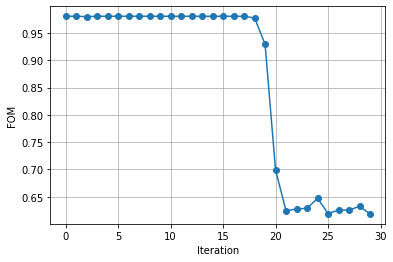

In [18]:
plt.figure()
plt.plot(evaluation_history,'o-')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('FOM')
plt.show()

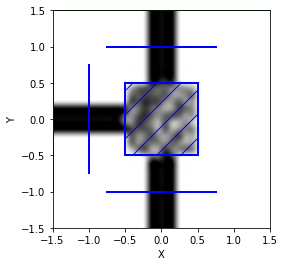

In [19]:
opt.update_design([x])
opt.plot2D(True,output_plane=mp.Volume(center=(0,0,0),size=(3,3,0)))
plt.show()